<H1><center>LDCOM - Predecir Ventas Futuras</center></H1>


### Descripción de los datos:
* ID - Representa una tupla (Tienda, Artículo) dentro del conjunto de prueba
* shop_id - Identificador único de cada Tienda
* item_id - Identificador único de cada Producto
* item_category_id - Identificador único de cada Categoría de Productos
* date_block_num - Consucutivo numérico por mes, usado a conveniencia. Enero 2013 es 0, Febrero 2013 es 1,..., Octubre 2015 es 33
* date - Fecha en formato dd/mm/yyyy
* item_cnt_day - Cantidad de productos vendidos. Está pronosticando una cantidad mensual de esta medida
* item_price - Precio del artículo
* item_name - Nombre del Artículo
* shop_name - Nombre de la Tienda
* item_category_name - Nombre de la Categoría


### Dependencias

In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

### Carga de la Información

In [2]:
test = pd.read_csv('input_ldcom/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 'item_id': 'int32'}, encoding='latin-1')
item_categories = pd.read_csv('input_ldcom/item_categories.csv',  dtype={'item_category_name': 'str', 'item_category_id': 'int32'}, encoding='latin-1')
items = pd.read_csv('input_ldcom/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 'item_category_id': 'int32'}, encoding='latin-1')
shops = pd.read_csv('input_ldcom/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'}, encoding='latin-1')
sales = pd.read_csv('input_ldcom/sales_train.csv', parse_dates=['date'], dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'}, encoding='latin-1')

### Fusión de Datasets

In [3]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

### Visualización de Datos sin procesar

In [4]:
print('Train rows: ', train.shape[0])
print('Train columns: ', train.shape[1])

Train rows:  2935849
Train columns:  10


In [5]:
train.head().T

,0,1,2,3,4
date,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-01-15 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.00,899.00,899.00,1709.05,1099.00
item_cnt_day,1,1,-1,1,1
item_name,Comic Book Ex librium Volume 1 And the door wi...,Software Workshop of ideas. Postcards -CD- (DV...,Software Workshop of ideas. Postcards -CD- (DV...,Practical annual report for 2012 (+ DVD). Unde...,Workshop on the program 1C: Simplified 8 (rev....
item_category_id,82,30,30,30,30
shop_name,Sucursal_no60,Sucursal_no26,Sucursal_no26,Sucursal_no26,Sucursal_no26
item_category_name,Accessories - PS2,Books - Fiction,Books - Fiction,Books - Fiction,Books - Fiction


In [6]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.62,1.24,44.78
std,9.42,16.23,6324.30,1726.44,2.62,15.07
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,37.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,56.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


### Período de Tiempo del Dataset

In [7]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


### Filtración de Datos

Acerca de las filtraciones de datos, solo se usará "shop_id" e "item_id" que aparecen en el conjunto de prueba.

In [8]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()

# Únicamente las tiendas que aparecen en set de pruebas
lk_train = train[train['shop_id'].isin(test_shop_ids)]

# Únicamente los artículos que aparecen en set de pruebas
lk_train = lk_train[lk_train['item_id'].isin(test_item_ids)]

In [9]:
print('Tamaño del dataset antes de las filtraciones:', train.shape[0])
print('Tamaño del dataset después de las filtraciones:', lk_train.shape[0])

Tamaño del dataset antes de las filtraciones: 2935849
Tamaño del dataset después de las filtraciones: 1224439


### Limpueza de Datos

Únicamente registros donde el valor "item_price" > 0.

In [10]:
train = train.query('item_price > 0')

### Proceso de Datos
* Se descartan las funciones de texto ya que no se hará nada con ellas.
* Se solicita pronosticar las ventas totales de cada producto y tienda en el próximo mes, los datos se dan por día, así que se eliminarán las columnas no deseadas y se agregarán los datos por mes.

In [11]:
# Seleccionar únicamente las características últiles
train_monthly = lk_train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

In [12]:
# Agrupar por mes "date_block_num" y agregar las características.
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})

# Renombrar las características
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

#### Para imitar el comportamiento real de los datos, es requerido que crear los registros faltantes del conjunto de datos cargado, por lo que para cada mes es necesario crear los registros faltantes para cada tienda y artículo, ya que no se tiene datos para ellos, se reemplazará con 0.

In [13]:
# Se crea un conjunto de datos con todas las combinaciones posibles de ['date_block_num', 'shop_id', 'item_id'] para que no falten registros.
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

In [14]:
# Combinar el conjunto de train con el conjunto complete (los registros faltantes se completarán con 0).
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)

### Nuevo Dataset

In [15]:
train_monthly.head().T

,0,1,2,3,4
date_block_num,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00
item_id,33.00,482.00,491.00,839.00,1007.00
item_category_id,2.00,19.00,19.00,19.00,19.00
item_price,499.00,3300.00,600.00,3300.00,1347.00
mean_item_price,499.00,3300.00,600.00,3300.00,449.00
item_cnt,1.00,1.00,1.00,1.00,3.00
mean_item_cnt,1.00,1.00,1.00,1.00,1.00
transactions,1.00,1.00,1.00,1.00,3.00


In [16]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6734448.00,16.50,9.81,0.00,8.00,16.50,25.00,33.00
shop_id,6734448.00,31.64,17.56,2.00,16.00,34.50,47.00,59.00
item_id,6734448.00,11041.89,6210.74,30.00,5385.25,11265.50,16068.25,22167.00
item_category_id,6734448.00,3.94,13.35,0.00,0.00,0.00,0.00,83.00
item_price,6734448.00,187.35,2171.80,0.00,0.00,0.00,0.00,515573.59
mean_item_price,6734448.00,81.13,531.16,0.00,0.00,0.00,0.00,42990.00
item_cnt,6734448.00,0.24,3.46,-4.00,0.00,0.00,0.00,2253.00
mean_item_cnt,6734448.00,0.10,0.61,-2.00,0.00,0.00,0.00,1000.00
transactions,6734448.00,0.18,0.90,0.00,0.00,0.00,0.00,31.00


In [17]:
# Extraer la fecha basado en las características.
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

### EDA

In [18]:
# Agrupación de la información para el Análisis EDA.
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

### ¿Cómo se comportan las ventas a lo largo del año?

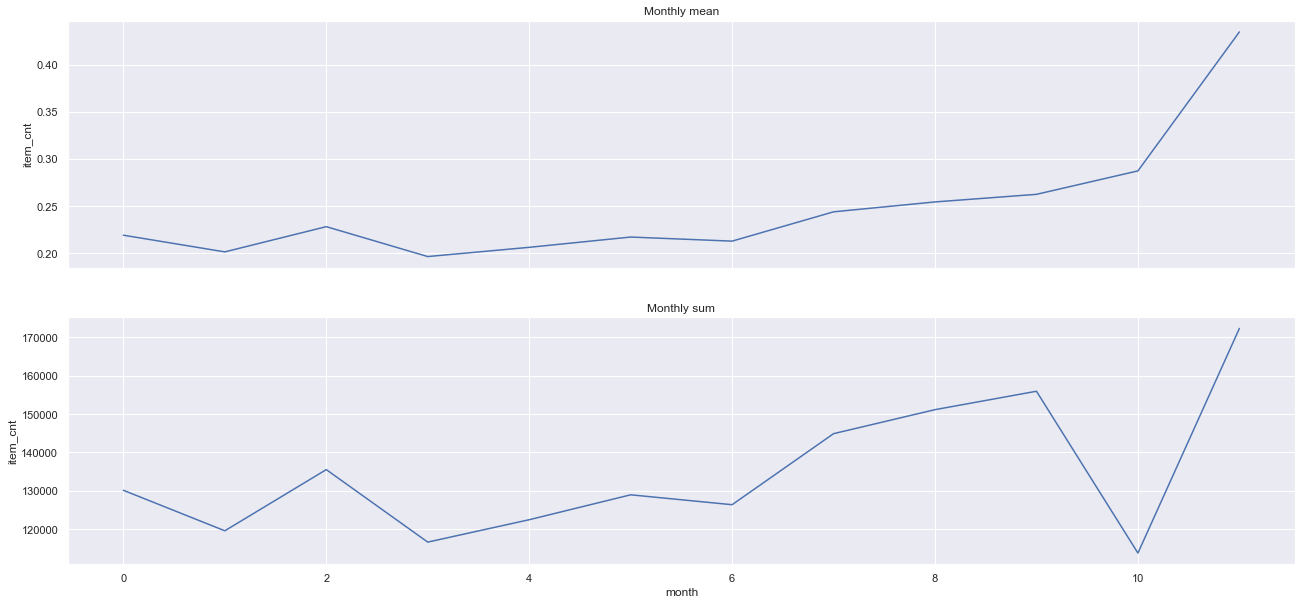

In [19]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

Es preciso apreciar que, se tiene un aumento en la tendencia del recuento de ventas de artículos (media) hacia el final del año.

### ¿Qué categoría es la que presenta mayor índice de ventas?

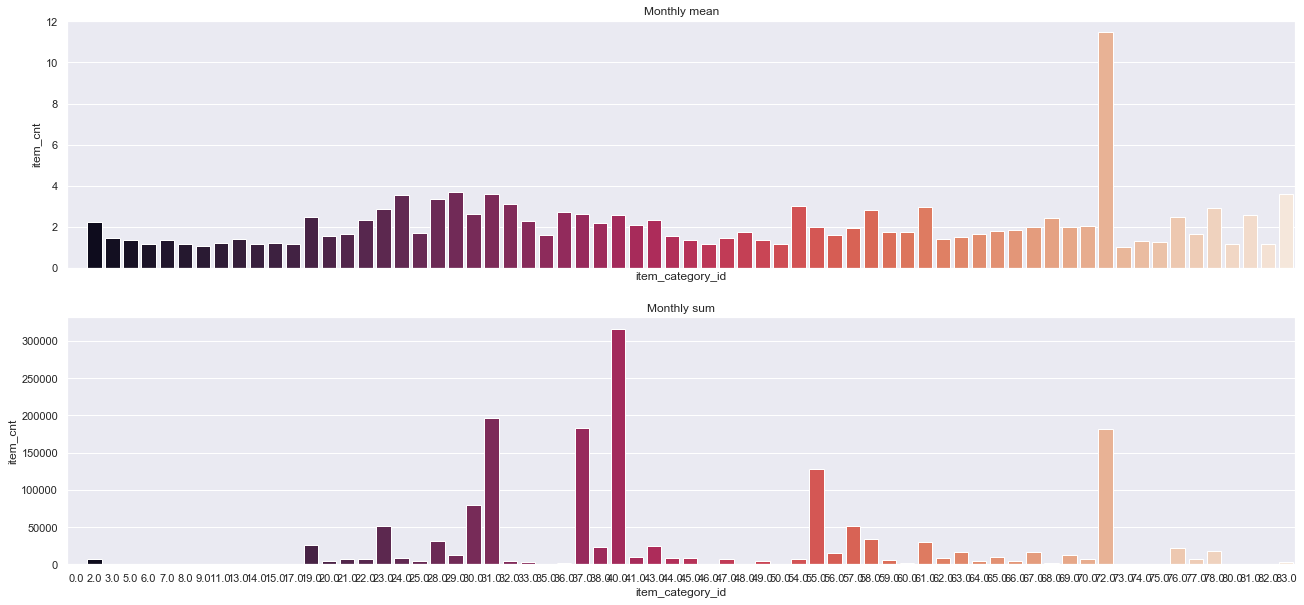

In [20]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

Solo algunas de las categorías parecen contener la mayor parte del recuento de ventas.

### ¿Qué tienda es la que más vende?

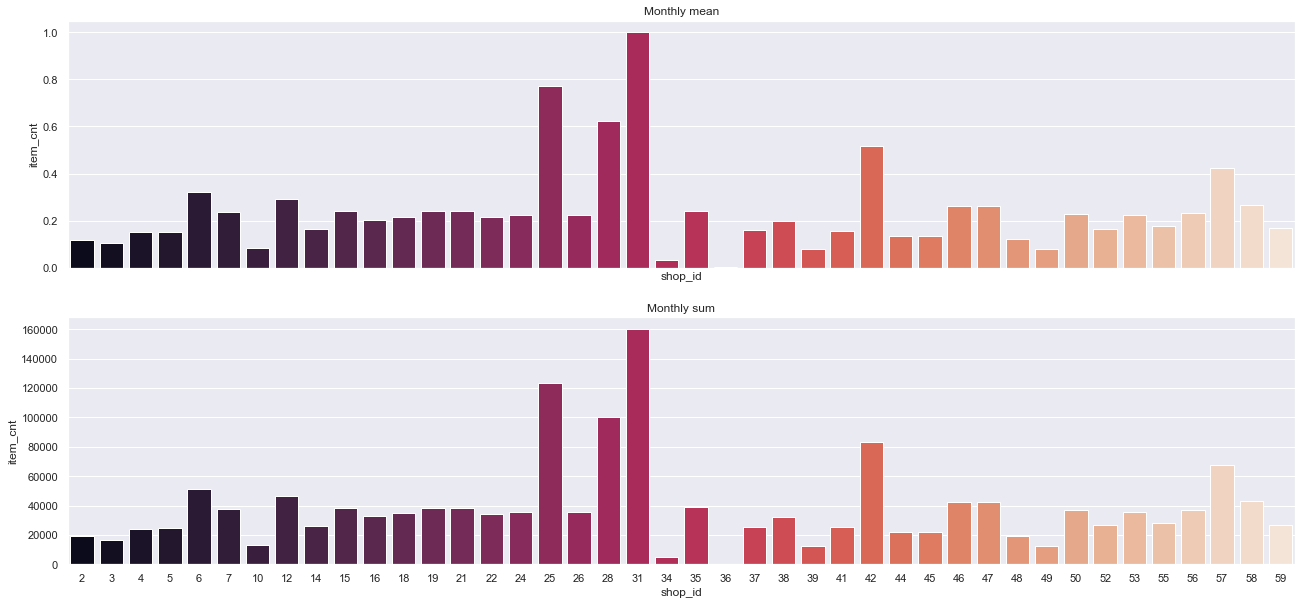

In [21]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

La mayoría de las tiendas tienen una tasa de venta similar, pero 3 de ellas tienen una tasa mucho más alta, esto puede ser un indicador del tamaño de la tienda.

### Comprobación de valores atípicos

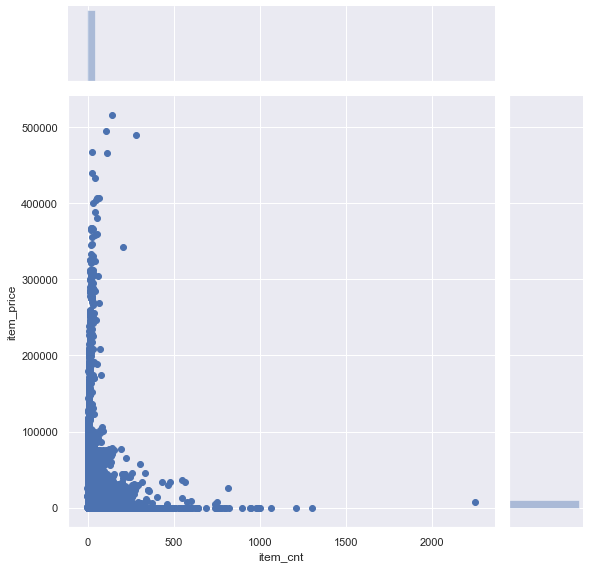

In [22]:
sns.jointplot(x="item_cnt", y="item_price", data=train_monthly, height=8)
plt.show()

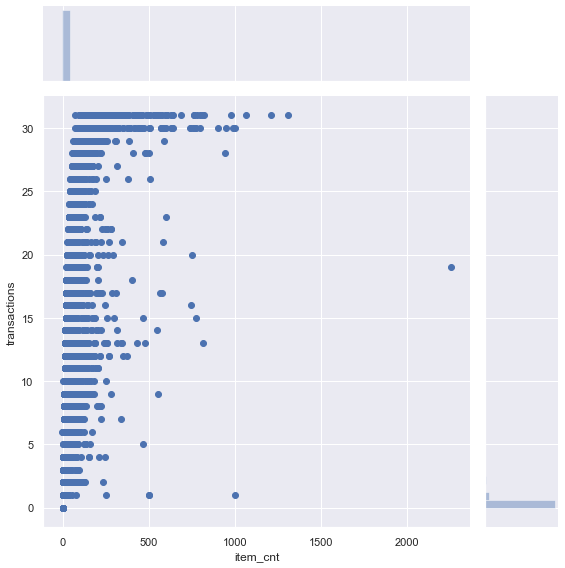

In [23]:
sns.jointplot(x="item_cnt", y="transactions", data=train_monthly, height=8)
plt.show()

### Distribución del atributo "item_cnt".

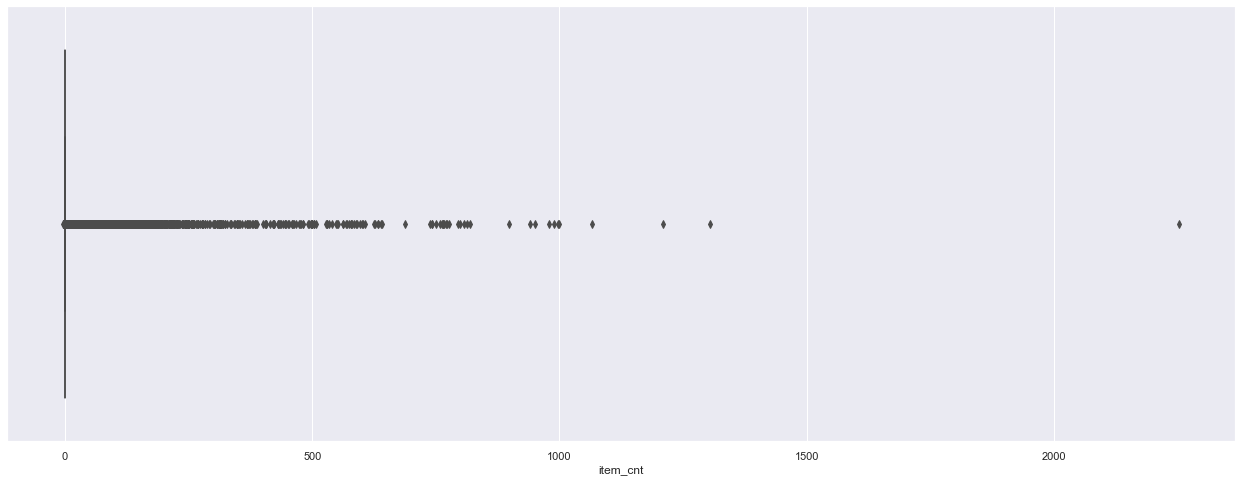

In [24]:
plt.subplots(figsize=(22, 8))
sns.boxplot(train_monthly['item_cnt'])
plt.show()

#### Se remueven los valore atípicos
Para los datos "item_cnt" > 20 y < 0, "item_price" >= 400000 se consideran valores artículos, por lo cual serán eliminados.

In [25]:
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20 and item_price < 400000')

### Creación de la Variable Dependiente
La etiqueta será sobre "item_cnt" del próximo mes, ya que estamos lidiando con un problema de pronóstico.

In [26]:
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

### Selección de Atributos

#### Precio de artículos unitariamente

In [27]:
train_monthly['item_price_unit'] = train_monthly['item_price'] // train_monthly['item_cnt']
train_monthly['item_price_unit'].fillna(0, inplace=True)

#### Atributos basados en grupos.

In [28]:
gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

train_monthly = pd.merge(train_monthly, gp_item_price, on='item_id', how='left')

#### ¿Cuánto cambió el precio de cada artículo desde su precio histórico (más bajo / más alto).

In [29]:
train_monthly['price_increase'] = train_monthly['item_price'] - train_monthly['hist_min_item_price']
train_monthly['price_decrease'] = train_monthly['hist_max_item_price'] - train_monthly['item_price']

#### Características basadas en la venta (venta = 3 meses).

In [30]:
# Valor mínimo
f_min = lambda x: x.rolling(window=3, min_periods=1).min()

# Valor máximo
f_max = lambda x: x.rolling(window=3, min_periods=1).max()

# Valor medio
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()

# Desviación Estándar
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    train_monthly[('item_cnt_%s' % function_name[i])] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

# Relleno de características vacías con 0
train_monthly['item_cnt_std'].fillna(0, inplace=True)

#### Características basadas en el retraso

In [31]:
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    
    # Relleno de características desplazadas con 0
    train_monthly[ft_name].fillna(0, inplace=True)

#### Tendencia de ventas de artículos

In [32]:
train_monthly['item_trend'] = train_monthly['item_cnt']

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly['item_trend'] -= train_monthly[ft_name]

train_monthly['item_trend'] /= len(lag_list) + 1

### Set de Datos después de la selección de características

In [33]:
train_monthly.head().T

,0,1,2,3,4
date_block_num,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00
item_id,33.00,482.00,491.00,839.00,1007.00
item_category_id,2.00,19.00,19.00,19.00,19.00
item_price,499.00,3300.00,600.00,3300.00,1347.00
mean_item_price,499.00,3300.00,600.00,3300.00,449.00
item_cnt,1.00,1.00,1.00,1.00,3.00
mean_item_cnt,1.00,1.00,1.00,1.00,1.00
transactions,1.00,1.00,1.00,1.00,3.00
year,2013.00,2013.00,2013.00,2013.00,2013.00


In [34]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6728118.00,16.50,9.81,0.00,8.00,16.00,25.00,33.00
shop_id,6728118.00,31.64,17.56,2.00,16.00,35.00,47.00,59.00
item_id,6728118.00,11042.87,6209.70,30.00,5386.00,11266.00,16068.00,22167.00
item_category_id,6728118.00,3.90,13.28,0.00,0.00,0.00,0.00,83.00
item_price,6728118.00,169.77,1792.01,0.00,0.00,0.00,0.00,366860.00
mean_item_price,6728118.00,79.71,522.27,0.00,0.00,0.00,0.00,42990.00
item_cnt,6728118.00,0.19,0.91,0.00,0.00,0.00,0.00,20.00
mean_item_cnt,6728118.00,0.09,0.31,0.00,0.00,0.00,0.00,20.00
transactions,6728118.00,0.17,0.74,0.00,0.00,0.00,0.00,19.00
year,6728118.00,2013.94,0.80,2013.00,2013.00,2014.00,2015.00,2015.00


### División de los conjuntos Train / Validation
* Se conoce que la prueba establecida para el futuro es intentar simular la misma distribución en los conjuntos Train / Validation.
* El conjunto de entrenamiento estará constituido por los primeros 3 a 28 bloques, la validación serán los últimos 5 bloques (29 a 32) y la prueba será con el bloque 33.
* Se dejarán los primeros 3 meses por fuera, porque estos fueron usados como una ventana de 3 meses para generar la selección de atributos, por lo que estos primeros 3 meses realmente no tendrán características útiles.

In [35]:
train_set = train_monthly.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = train_monthly.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = train_monthly.query('date_block_num == 33').copy()

train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

print('Registros del conjunto de Entrenamiento:', train_set.shape[0])
print('Registros del conjunto de Validación:', validation_set.shape[0])
print('Registros del conjunto de Prueba:', test_set.shape[0])

print('Registros del conjunto de Entrenamiento: %s (%.f%% de datos completos)' % (train_set.shape[0], ((train_set.shape[0]/train_monthly.shape[0])*100)))
print('Registros del conjunto de Validación: %s (%.f%% de datos completos)' % (validation_set.shape[0], ((validation_set.shape[0]/train_monthly.shape[0])*100)))

Registros del conjunto de Entrenamiento: 4946785
Registros del conjunto de Validación: 989412
Registros del conjunto de Prueba: 197879
Registros del conjunto de Entrenamiento: 4946785 (74% de datos completos)
Registros del conjunto de Validación: 989412 (15% de datos completos)


### Codificación de la Media
* Después de la división de los conjuntos Train / Validation.

In [36]:
# Codificación de la Media por Tienda
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)

# Codificación de la Media por Artículo
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)

# Codificación de la Media entre Tienda y Artículo
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)

# Codificación de la Media del Año
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)

# Codificación de la Media del Mes
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

# Se agregan las codificaciones de la media en el set de datos de Entrenamiento
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')

# Se agregan las codificaciones de la media en el set de datos de Validación
validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

In [37]:
# Se crea la variable dependiente en los set de datos de Entrenamiento y Validación
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [38]:
# Parseo de atributos a tipo Numérico
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

### Construcción del Conjunto de Pruebas
La idea principal es predecir para "date_block_num" = 34, por lo que el conjunto de pruebas será el bloque 33 y las predicciones deben reflejar los valores del bloque 34. En otras palabras, se usará el bloque 33 porque se desea pronosticar valores para el bloque 34.

In [39]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

### Se remplazan los valores vacíos

In [40]:
sets = [X_train, X_validation, X_test]

# Remplazando los valores vacíos con el valor medio de cada tienda.            
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
# Remplazando los valores vacíos con el valor medio de cada tienda en el data set de Prueba.   
X_test.fillna(X_test.mean(), inplace=True)

In [41]:
# I'm dropping "item_category_id", we don't have it on test set and would be a little hard to create categories for items that exist only on test set.
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

### Conjunto de Pruebas

In [42]:
X_test.head().T

,0,1,2,3,4
shop_id,5.00,5.00,5.00,5.00,5.00
item_id,5037.00,5320.00,5233.00,5232.00,5268.00
item_price,749.50,0.00,2997.00,0.00,0.00
mean_item_price,749.50,0.00,999.00,0.00,0.00
item_cnt,1.00,0.00,3.00,0.00,0.00
mean_item_cnt,1.00,0.00,1.00,0.00,0.00
transactions,1.00,0.00,3.00,0.00,0.00
year,2015.00,2015.00,2015.00,2015.00,2015.00
month,9.00,9.00,9.00,9.00,9.00
item_price_unit,749.00,0.00,999.00,0.00,0.00


In [43]:
X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
shop_id,214200.00,31.64,17.56,2.00,16.00,34.50,47.00,59.00
item_id,214200.00,11019.40,6252.64,30.00,5381.50,11203.00,16071.50,22167.00
item_price,214200.00,239.98,1854.07,0.00,0.00,0.00,0.00,166944.50
mean_item_price,214200.00,133.82,865.39,0.00,0.00,0.00,0.00,32990.00
item_cnt,214200.00,0.23,0.95,0.00,0.00,0.00,0.00,20.00
mean_item_cnt,214200.00,0.13,0.37,0.00,0.00,0.00,0.00,10.00
transactions,214200.00,0.20,0.73,0.00,0.00,0.00,0.00,15.00
year,214200.00,2015.00,0.00,2015.00,2015.00,2015.00,2015.00,2015.00
month,214200.00,9.00,0.00,9.00,9.00,9.00,9.00,9.00
item_price_unit,214200.00,inf,nan,0.00,0.00,0.00,0.00,inf


### Modelado de la Información

#### Función de graficación

In [44]:
def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg", height=7)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()


## Modelo basado en Árboles

### Random forest

In [45]:
# Se usa únicamente las características importantes para random forest.
rf_features = ['shop_id', 'item_id', 'item_cnt', 'transactions', 'year',
               'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
               'shop_mean', 'item_mean', 'item_trend', 'mean_item_cnt']
rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

In [46]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [47]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

In [48]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, rf_val_pred)))

Train rmse: 0.6987440500897693
Validation rmse: 0.7756929399144616


### Desempeño de Random Forest con la gráfica de "Prediction x Label"

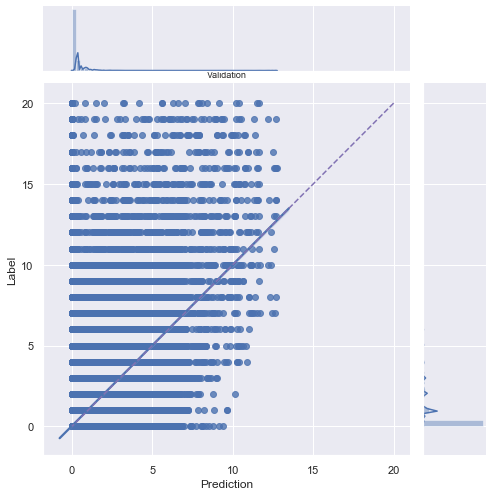

In [49]:
# model_performance_sc_plot(rf_train_pred, Y_train, 'Train')
model_performance_sc_plot(rf_val_pred, Y_validation, 'Validation')

## Modelo basado en Lineal

### Linear Regression

In [50]:
# Se usa únicamente las características importantes para linear Regression
lr_features = ['item_cnt', 'item_cnt_shifted1', 'item_trend', 'mean_item_cnt', 'shop_mean']
lr_train = X_train[lr_features]
lr_val = X_validation[lr_features]
lr_test = X_test[lr_features]

#### Normalización de características

In [51]:
lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)
lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)

In [52]:
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [53]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)

In [54]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, lr_val_pred)))

Train rmse: 0.7347132326333325
Validation rmse: 0.7755311093538375


### Desempeño de Linear Regression con la gráfica de "Prediction x Label"

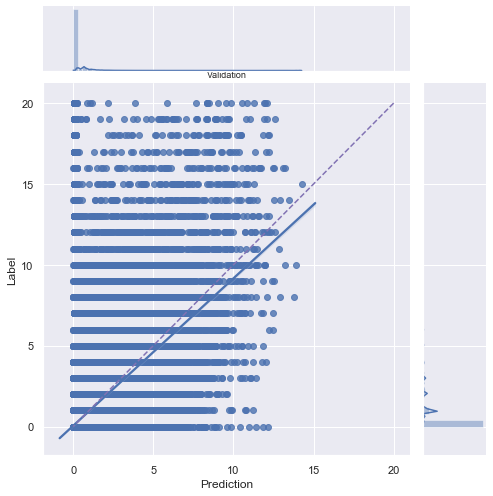

In [55]:
# model_performance_sc_plot(lr_train_pred, Y_train, 'Train')
model_performance_sc_plot(lr_val_pred, Y_validation, 'Validation')

## Modelo basado en Clustering

### KNN Regressor

In [56]:
# Se usa únicamente las características importantes para KNN
knn_features = ['item_cnt', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1',
                'item_cnt_shifted2', 'shop_mean', 'shop_item_mean', 
                'item_trend', 'mean_item_cnt']

# Conjunto de Train de submuestra (si se usa todos los datos, esto tomará demasiado tiempo).
X_train_sampled = X_train[:100000]
Y_train_sampled = Y_train[:100000]

knn_train = X_train_sampled[knn_features]
knn_val = X_validation[knn_features]
knn_test = X_test[knn_features]

#### Normalizing features

In [57]:
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_test = knn_scaler.transform(knn_test)

In [58]:
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, Y_train_sampled)

KNeighborsRegressor(algorithm='auto', leaf_size=13, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                    weights='uniform')

In [59]:
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
knn_test_pred = knn_model.predict(knn_test)

In [60]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_sampled, knn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, knn_val_pred)))

Train rmse: 0.48745547438322284
Validation rmse: 0.8004038971898291


### Desempeño de K-NN con la gráfica de "Prediction x Label"

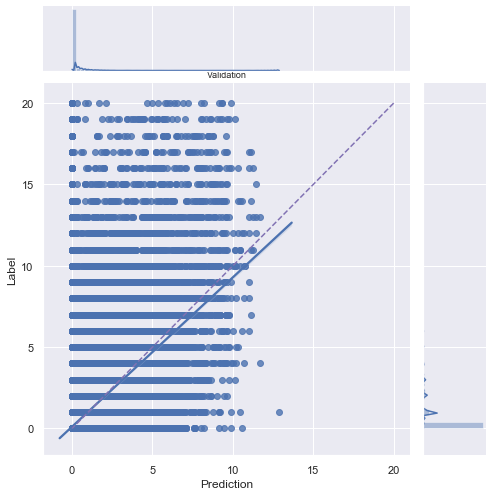

In [61]:
# model_performance_sc_plot(knn_train_pred, Y_train_sampled, 'Train')
model_performance_sc_plot(knn_val_pred, Y_validation, 'Validation')

### Creación de nuevos conjuntos de datos con las predicciones de los modelos de primer nivel
* ASe usará una técnica de ensamblaje simple, usando las predicciones de los modelos de primer nivel como entrada para el modelo de segundo nivel, de esta manera el modelo de segundo nivel básicamente usará las predicciones de los modelos de primer nivel como características y aprenderá dónde dar más peso.
* Para usar esta técnica también es necesario usar los modelos de primer nivel y hacer predicciones en el conjunto de prueba, para poder usarlos en el modelo de segundo nivel.
* También se podría pasar el conjunto completo de validación con características adicionales (la predicción de los modelos de primer nivel) al modelo de segundo nivel y dejar que trabaje un poco más para encontrar la solución.

In [62]:
# Conjunto de datos que será el conjunto de Entrenamiento.
first_level = pd.DataFrame(rf_val_pred, columns=['random_forest'])
first_level['linear_regression'] = lr_val_pred
first_level['knn'] = knn_val_pred
first_level['label'] = Y_validation.values
first_level.head(20)

,random_forest,linear_regression,knn,label
0,0.51,0.60,0.22,0
1,0.45,0.04,0.22,0
2,0.20,0.04,0.00,0
3,0.20,0.04,0.00,0
4,0.20,0.04,0.00,0
5,0.20,0.04,0.00,0
6,0.20,0.04,0.00,0
7,0.20,0.04,0.00,0
8,0.20,0.04,0.00,0
9,0.05,0.04,0.00,0


In [63]:
# Conjunto de datos que será el conjunto de Prueba.
first_level_test = pd.DataFrame(rf_test_pred, columns=['random_forest'])
first_level_test['linear_regression'] = lr_test_pred
first_level_test['knn'] = knn_test_pred
first_level_test.head()

,random_forest,linear_regression,knn
0,0.97,0.85,0.89
1,0.06,0.06,0.00
2,0.84,1.79,1.11
3,0.00,0.06,0.00
4,0.06,0.06,0.00


### Ensamblando

* Para combinar las predicciones del modelo de primer nivel, se usará una regresión lineal simple.
* Como solo se está alimentando al modelo con predicciones, no es necesario un modelo complejo.

#### Arquitectura de Ensamblado:
* 1er Nivel:
    * Random forest
    * Linear Regression
    * KNN
* 2ndo Nivel;
    * Linear Regression

#### Imagen para entender mejor el proceso:
 
 <img src="img/Grafica_Modelos.jpg" width="400">

### El 2ndo nivel corresponde al modelo de linear regression
* Este es el modelo que combinará los otros para hacer una mejor predicción general.
* Si las entradas a este modo fueran más complejas, se podría dividir los datos en el conjunto de Entrenamiento y de Validación nuevamente, de esta manera se puede verificar si el modelo está sobreajustado.

In [64]:
meta_model = LinearRegression(n_jobs=-1)

#### Entrenado en el conjunto de validación utilizando las predicciones de los modelos de primer nivel

In [65]:
# Drop label from dataset.
first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, Y_validation)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

#### Efectuando predicciones en el conjunto de pruebas utilizando las predicciones de modelos de primer nivel

In [66]:
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)

#### Conjunto de métricas del modelo en el conjunto de validación

In [67]:
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_pred, Y_validation)))

Train rmse: 0.7661838686285163


#### Desempeño del modelo ajustado con la gráfica de "Prediction x Label".

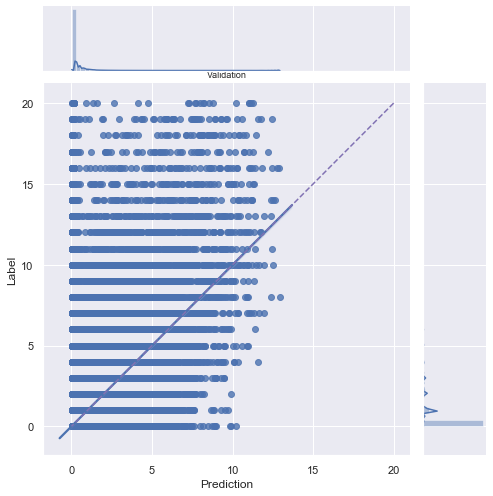

In [68]:
model_performance_sc_plot(ensemble_pred, Y_validation, 'Validation')

#### Predicciones efectuadas.

In [69]:
prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = final_predictions.clip(0., 20.)
prediction_df.to_csv('submission.csv', index=False)
prediction_df.head(10)

,ID,item_cnt_month
0,0,0.95
1,1,0.09
2,2,1.34
3,3,0.06
4,4,0.09
5,5,1.01
6,6,1.37
7,7,0.21
8,8,1.98
9,9,0.06
